In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

from train_utils import plot_confusion_matrix, make_dataframe
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print("Tensorflow version is ", tf.__version__)

Tensorflow version is  1.13.1


Using TensorFlow backend.


## setup training

In [2]:
width_image = 224
height_image = 224
batch_size = 32
img_shape = (width_image, height_image, 3)

categories = os.listdir('dataset\\v2')
data_frames = make_dataframe('dataset\\v2', validation_percentage = 0.13, test_percentage=0.17)

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15.
)
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

Total size:  403
Training set size:  283
Validation set size:  53
Test set size:  67
Total size:  501
Training set size:  351
Validation set size:  66
Test set size:  84
Total size:  410
Training set size:  288
Validation set size:  54
Test set size:  68
Total size:  594
Training set size:  417
Validation set size:  78
Test set size:  99
Total size:  527
Training set size:  370
Validation set size:  69
Test set size:  88


In [ ]:
# make generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_frames[0],
    x_col='path',
    y_col='label',
    class_mode = 'categorical',
    target_size = (width_image, height_image),
    batch_size = batch_size)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=data_frames[1],
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    target_size=(width_image, height_image),
    batch_size = batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_frames[2],
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    target_size=(width_image, height_image),
    batch_size = batch_size,
    shuffle=False
)

In [ ]:
# get pre-trained MobileNet V2
#base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
#                                                include_top=False,
#                                                weights='imagenet')

#base_model = tf.keras.applications.InceptionResNetV2(input_shape=img_shape,
#                                                include_top=False,
#                                                weights='imagenet')

base_model = tf.keras.applications.densenet.DenseNet121(input_shape=img_shape,
                                                include_top=False,
                                                weights='imagenet')

# feature extraction reuse, True for fine-tuning see tensorflow
base_model.trainable = False

## create model over pre-trained net

In [ ]:
# create model over pre-trained graph
model = tf.keras.Sequential([
    base_model,
#    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
#                       activation=tf.nn.relu, input_shape=(len(categories),)),
#    keras.layers.Dropout(0.5),
#    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
#                       activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(len(categories), activation='softmax')
])

In [ ]:
# add the optmizer, loss function and metric for evaluate the training
optimizer = keras.optimizers.Adam()
# optimizer = keras.optimizers.Nadam()
# optimizer = keras.optimizers.Adadelta()
# tensorflow guide use:
#optimizer = tf.keras.optimizers.RMSprop(lr=0.0001)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

## Tranining Phase

In [ ]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
test_steps = test_generator.n // batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs, 
    validation_data = validation_generator,
    validation_steps = validation_steps
)

## Fine tuning

In [ ]:
print(train_generator.n)
#Enable chage of all net weight's including the pre-trained
epochs_fine = 200
model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
# set the level to fine-tune
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
# recompile model with optimizer
optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
#optimizer = tf.keras.optimizers.RMSprop(lr=2e-5)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

In [ ]:
# fit fine-tuning
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs = epochs_fine,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

## Plotting Validation accuracy/loss

In [ ]:
%matplotlib inline

# training and validation accuracy/loss
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

if('history_fine' in globals()):
    acc += history_fine.history['acc']
    val_acc += history_fine.history['val_acc']
    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Plotting confusion matrix

In [ ]:
# confusion matrix
Y_pred = model.predict_generator(test_generator, test_steps)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

# classification report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=categories))

# evaluate keras model with model.evaluate()
x, y = zip(*(test_generator[i] for i in range(len(test_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: {0:0.1f}%".format(acc * 100))
print("Loss: {0:0.1f}%".format(loss * 100))


plot_confusion_matrix(test_generator.classes, y_pred, categories)

In [ ]:
# save the model
name = 'adam_densnet121_fine_tuning.h5'
model.save(name)

# SVM

In [3]:
base_model_extractor = tf.keras.applications.densenet.DenseNet121(
    input_shape=img_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
# create model over pre-trained graph, its same to pass pooling='avg'
#model_extractor = tf.keras.Sequential([
#   base_model_extractor
#    keras.layers.GlobalAveragePooling2D()
#])
from tensorflow.keras.models import Model

model = keras.models.load_model('.\\saved_model\\adam_densnet121_fine_tuning.h5')

model.summary()
model = Model(model.input, model.layers[-2].output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 1024)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 4,783,109
Non-trainable params: 2,259,520
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121_input (InputLaye (None, 224, 224, 3)       0         
__________________________________________________________

In [10]:
import os
 
import sklearn
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.externals import joblib
     
def extract_features(generator, model, size):
    features = np.empty((size, 1024))
    labels = []
    for i in range(0, size):
        img, label = generator.next()
        feature = model.predict(img)
        features[i,:] = np.squeeze(feature)
        labels.append(categories[np.argmax(label)])
        print("{0:.0f}%".format((i/size) * 100), end="\r")
    return features, np.array(labels)

In [11]:
# create from all dataset, the svm split into training and test sets
train_svm_generator = train_datagen.flow_from_directory(
    directory='dataset\\v2',
    class_mode = 'categorical',
    target_size = (width_image, height_image),
    batch_size = 1)

Found 2435 images belonging to 5 classes.


In [12]:
features, labels = extract_features(train_svm_generator, model, size=len(train_svm_generator))

In [13]:
model_output_path = './ciao.h5'
#train_svm_classifer(features, labels, model_output_path):
"""
train_svm_classifer will train a SVM, saved the trained and SVM model and
report the classification performance

features: array of input features
labels: array of labels associated with the input features
model_output_path: path for storing the trained svm model
"""
# save 20% of data for performance evaluation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

param = [
 #   {
 #       "kernel": ["linear"],
 #       "C": [1, 10, 100, 1000]
 #   },
    {
        "kernel": ["rbf"],
        "C": [10],#[1, 10, 100, 1000],
        "gamma": [1e-2, 1e-3]#, 1e-4, 1e-5]
    }
]

# request probability estimation
svm = SVC(probability=True)

# 10-fold cross validation, use 4 thread as each fold and each parameter set can be train in parallel
clf = GridSearchCV(svm, param,
        cv=10, n_jobs=5, verbose=3)

clf.fit(X_train, y_train)

if os.path.exists(model_output_path):
    joblib.dump(clf.best_estimator_, model_output_path)
else:
    print("Cannot save trained svm model to {0}.".format(model_output_path))

print("\nBest parameters set:")
print(clf.best_params_)

y_predict=clf.predict(X_test)

labels=sorted(list(set(labels)))
print("\nConfusion matrix:")
print("Labels: {0}\n".format(",".join(labels)))
print(confusion_matrix(y_test, y_predict, labels=labels))

print("\nClassification report:")
print(classification_report(y_test, y_predict))

# Calcolo accuratezza
print('Accuratezza media della combinazione migliore: %.3f' % clf.best_score_)
print('Accuratezza sul training set: %.3f' % clf.score(X_train, y_train))
print('Accuratezza sul validation set: %.3f' % clf.score(X_test, y_test))

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  20 | elapsed:  2.4min remaining:   15.9s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  2.4min finished


Cannot save trained svm model to ./ciao.h5.

Best parameters set:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Confusion matrix:
Labels: cardboard,glass,metal,paper,plastic

[[ 75   0   0   8   1]
 [  0  89   3   0   6]
 [  2   8  71   3   4]
 [  4   0   1 108   0]
 [  3   4   3   3  91]]

Classification report:
              precision    recall  f1-score   support

   cardboard       0.89      0.89      0.89        84
       glass       0.88      0.91      0.89        98
       metal       0.91      0.81      0.86        88
       paper       0.89      0.96      0.92       113
     plastic       0.89      0.88      0.88       104

    accuracy                           0.89       487
   macro avg       0.89      0.89      0.89       487
weighted avg       0.89      0.89      0.89       487

Accuratezza media della combinazione migliore: 0.894
Accuratezza sul training set: 1.000
Accuratezza sul validation set: 0.891


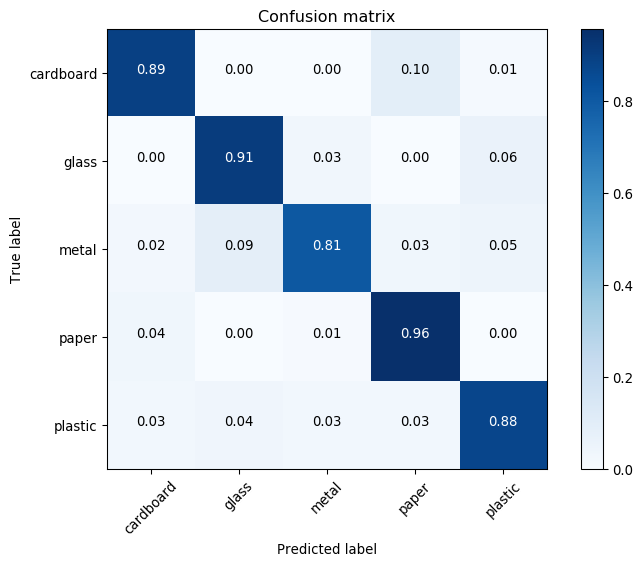

In [16]:
plot_confusion_matrix(y_test, y_predict, labels)

## Try predict 

In [20]:
from keras.preprocessing import image

model_prediction = keras.models.load_model('.\\saved_model\\adam_densnet121_fine_tuning.h5')
model_prediction.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

x = image.load_img('metal.jpg', target_size=(width_image, height_image))
x = image.img_to_array(x)
x = x.reshape((1,) + x.shape)
x = x/255.

print(model_prediction.predict(x))
print(model_prediction.predict_classes(x, batch_size=1))

[[0.01180736 0.01485037 0.01827549 0.06629909 0.88876766]]
[4]


In [33]:
x = image.load_img('metal.jpg', target_size=(width_image, height_image))
x = image.img_to_array(x)
x = x.reshape((1,) + x.shape)
x = x/255.
feature = model.predict(img)
print(feature.shape)

y_predict=clf.predict(np.squeeze(img))
print(y_predict)

ValueError: Error when checking input: expected densenet121_input to have 4 dimensions, but got array with shape (1, 1, 224, 224, 3)